# Regression Continued 
## Objectives 
- Scaling - chat about fit/transform 
- Use correlations and recursive algorithms to inform feature selection
- More Feature Engineering 
- Creating Interactions between features
- Use `PolynomialFeatures` to build compound features

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#this allows plots to appear directly in the notebook
%matplotlib inline
plt.style.use('fivethirtyeight')

#sklearn imports for feature selection, scaling and polynomial features
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

#importing data
wine = pd.read_csv('data/wine.csv')
wine.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,1
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,1
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,1
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,1
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,1


Let's imagine that we're going to try to predict wine quality based on specific features about each wine. 

### Decisions, Decisions, Decisions...

Now: Which columns (predictors) should I choose? 

There are 12 predictors I could choose from. For each of these predictors, I could either use it or not use it in my model, which means that there are $2^{12} = 4096$ _different_ models I could construct! Well, okay, one of these is the "empty model" with no predictors in it. But there are still 4095 models from which I can choose.

How can I decide which predictors to use in my model? Let's explore our options. 

1. Our first attempt might be just see which features are _correlated_ with the target to make a prediction.

We can use the correlation metric in making a decision.

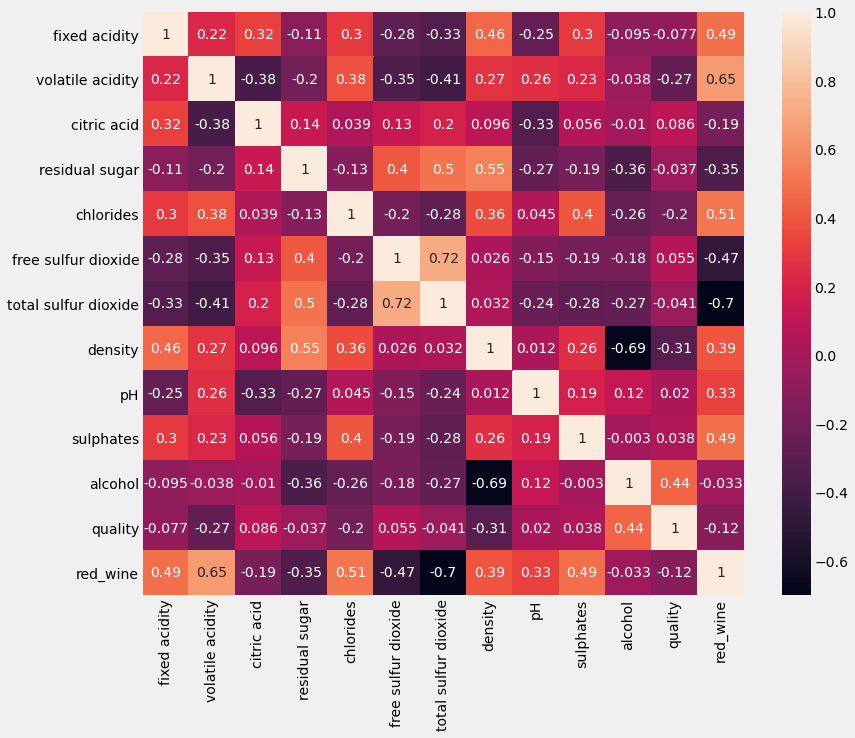

In [2]:
plt.figure(figsize=(12,10))
#alternative way
#sns.set(rc={'figure.figsize':(8, 8)})
ax = sns.heatmap(wine.corr(), annot=True);# Let's look at the correlations with 'quality'
# (our dependent variable) in particular.



In [3]:
# Let's look at the correlations with 'quality'
# (our dependent variable) in particular.

wine_corrs = wine.corr()['quality'].map(abs).sort_values(ascending=False)
wine_corrs

quality                 1.000000
alcohol                 0.444319
density                 0.305858
volatile acidity        0.265699
chlorides               0.200666
red_wine                0.119323
citric acid             0.085532
fixed acidity           0.076743
free sulfur dioxide     0.055463
total sulfur dioxide    0.041385
sulphates               0.038485
residual sugar          0.036980
pH                      0.019506
Name: quality, dtype: float64

Let's try using only a subset of the strongest correlated features to make our model.

In [4]:
# Let's choose 'alcohol' and 'density'.

wine_preds = wine[['alcohol', 'density', 'volatile acidity', 'chlorides']]
wine_target = wine['quality']

In [5]:
lr = LinearRegression()

In [6]:
lr.fit(wine_preds, wine_target)

LinearRegression()

In [7]:
lr.score(wine_preds, wine_target)

0.2673766696102273

### Let's try recursive feature elimination 

The idea behind recursive feature elimination is to start with all predictive features and then build down to a small set of features slowly, by eliminating the features with the lowest coefficients.

That is:

1. Start with a model with _all_ $n$ predictors
2. find the predictor with the smallest effect (coefficient)
3. throw that predictor out and build a model with the remaining $n-1$ predictors
4. set $n = n-1$ and repeat until $n-1$ has the value you want!

### But first.. we should _scale_ our data 
The idea behind StandardScaler is that it will transform your data so its distribution will have a mean value 0 and standard deviation of 1. In case of multivariate data(multiple features), this is done feature-wise(independently for each column of the data)

In [9]:
ss = StandardScaler()
#what is the fit method doing?
ss.fit(wine.drop('quality', axis=1))
#what about transform?
wine_scaled = ss.transform(wine.drop('quality', axis=1))

In [14]:
#initializing a regression instance and RFE
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=4)

In [15]:
select.fit(X=wine_scaled, y=wine['quality'])

RFE(estimator=LinearRegression(), n_features_to_select=4)

In [12]:
list(zip(wine.columns, select.support_))

[('fixed acidity', False),
 ('volatile acidity', True),
 ('citric acid', False),
 ('residual sugar', False),
 ('chlorides', False),
 ('free sulfur dioxide', False),
 ('total sulfur dioxide', False),
 ('density', False),
 ('pH', False),
 ('sulphates', False),
 ('alcohol', True),
 ('quality', True)]

In [13]:
list(zip(wine.columns, select.ranking_))

[('fixed acidity', 5),
 ('volatile acidity', 1),
 ('citric acid', 10),
 ('residual sugar', 2),
 ('chlorides', 9),
 ('free sulfur dioxide', 7),
 ('total sulfur dioxide', 8),
 ('density', 3),
 ('pH', 6),
 ('sulphates', 4),
 ('alcohol', 1),
 ('quality', 1)]

## Feature Engineering 
> Remember: Domain knowledge can be helpful here! 🧠

In practice this aspect of data preparation can constitute a huge part of the data scientist's work. As we move into data modeling, much of the goal will be a matter of finding––**or creating**––features that are predictive of the targets we are trying to model.

There are infinitely many ways of transforming and combining a starting set of features. Good data scientists will have a nose for which engineering operations will be likely to yield fruit and for which operations won't. And part of the game here may be getting someone else on your team who understands what the data represent better than you!

**Let's do a bit of EDA and look at the chlorides column.**

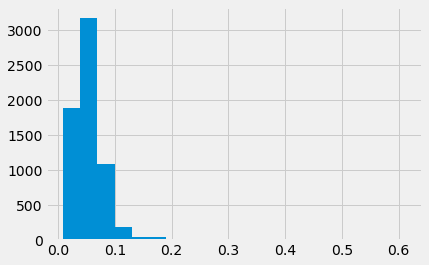

In [16]:
#looking at the distribution 
wine['chlorides'].hist(bins=20);

In [17]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


**We'll try building a feature that records whether the level of chlorides is greater than 0.065 (based on "high" being greater than the 75th percentile)**

In [18]:
wine['high_chlorides'] = wine['chlorides'] > 0.065

**Now we can check the correlation of this new feature with the target**

In [19]:
wine.corr()['quality']['high_chlorides']

-0.18185264331647868

Not bad! We don't seem to have stumbled onto a huge connection here, but this correlation value suggests that this new feature may be helpful in a final model.

## Interactions - Products of features 
Another engineering strategy we might try is **multiplying features together**.
Let's try these two features: `residual sugar` and `total sulfur dioxide`. Note that without domain knowledge or exploration, this is really a guess that this combination will predict `quality` well.

In [20]:
wine['rs*tsd'] = wine['residual sugar'] * wine['total sulfur dioxide']

In [21]:
wine.corr()['quality']['rs*tsd']

-0.06622845877790091

In [22]:
wine.corr()['quality']['residual sugar']

-0.03698048458576987

In [23]:
wine.corr()['quality']['total sulfur dioxide']

-0.04138545385560974

We can see these two features together have a higher correlation than each by itself!

## Polynomial Features

Instead of just multiplying features at random, we might consider trying **every possible product of features**. That's what PolynomialFeatures can do. Along with raising each feature to the specified polynomial degree. 

In [24]:
pf = PolynomialFeatures(degree=3)

X = wine.drop('quality', axis=1)
y = wine['quality']

# Fitting the PolynomialFeatures object
pf.fit(X)

PolynomialFeatures(degree=3)

In [25]:
pdf = pd.DataFrame(pf.transform(X), columns=pf.get_feature_names())
pdf

,1,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x11^3,x11^2 x12,x11^2 x13,x11 x12^2,x11 x12 x13,x11 x13^2,x12^3,x12^2 x13,x12 x13^2,x13^3
0,1.0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,...,1.0,1.0,64.6,1.0,64.6,4173.16,1.0,64.6,4173.16,2.695861e+05
1,1.0,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,...,1.0,1.0,174.2,1.0,174.2,30345.64,1.0,174.2,30345.64,5.286210e+06
2,1.0,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,...,1.0,1.0,124.2,1.0,124.2,15425.64,1.0,124.2,15425.64,1.915864e+06
3,1.0,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,...,1.0,1.0,114.0,1.0,114.0,12996.00,1.0,114.0,12996.00,1.481544e+06
4,1.0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,...,1.0,1.0,64.6,1.0,64.6,4173.16,1.0,64.6,4173.16,2.695861e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,1.0,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,3.189506e+06
6493,1.0,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,2.427716e+09
6494,1.0,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,2.363266e+06
6495,1.0,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,1.771561e+06


In [26]:
pdf.shape

(6497, 680)

In [27]:
lr = LinearRegression()

lr.fit(pdf, y)

LinearRegression()

In [28]:
lr.score(pdf, y)

0.49018967411270087

So: Is this a good idea? What are the potential dangers here?